# ML for Economic Analysis Project 1 - Peru
Mingmin Feng; Jingyan Yang; Yu Pan; Rachid Ben Maatoug; Nataell Cornu
## 1 Problem Description
This report is a replication and extension of Hanna and Olken's study about predicting per-capita consumption by using information of observable assets for per household in Peru. We add new assets features which are not used by Hanna and Olken and also create more than four thousands interactions specifically for Lasso. We use machine learning techniques such as K-nearest Neighbors, Support Vector Machine Regression, Light Gradient Boosting Machine and Neural Network to predict the poverty status of households on the testing sample. We find that Lasso and Light Gradient Boosting Machine preform better than other models after comparing their MSE. In the end, we also replicate the welfare analysis with the new proxy-means test and compare it to the original one.


In [1]:
# install packages
# !pip install scikit-neuralnetwork
# !pip install lightgbm
# ! pip install mlxtend
# ! pip install yellowbrick

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
#Import everything
import pandas as pd
import numpy as np
from numpy.linalg import inv
from numpy.random import normal as rnorm
import itertools
import time
import statsmodels.api as sm
import random

# for plot
import seaborn as sns
#stata-like output
import statsmodels.api as sm
import statsmodels.formula.api as smf

#for missing values
import missingno as msno
from sklearn.impute import SimpleImputer

In [3]:
 #regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn import neural_network
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

In [4]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# import yellowbrck for graphs
from yellowbrick.datasets import load_credit
from yellowbrick.features import Rank2D
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor.alphas import alphas

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# 2 Data Preprocessing
We check the missing value of data, visulize the data to get a "feel", impute the missing value with median, and split the data into trainning and test set.

## 2.1 Dataset acquisition
we use pd.read_csv to read the csv file as dataframe data type.

In [5]:
# Peru data
peru = pd.read_csv('datasets/Project1_CompletaData_96.csv')
peru.head()
# Overview of all variables
peru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46305 entries, 0 to 46304
Columns: 105 entries, lnpercapitaconsumption to percapitahat_OLS
dtypes: float64(41), int64(64)
memory usage: 37.1 MB


## 2.2 Cleaning the Data
We check our dataset by detecting whether it contains null, Nan values or missing values.

In [6]:
peru.isnull().sum()

lnpercapitaconsumption      0
d_fuel_other                0
d_fuel_wood                 0
d_fuel_coal                 0
d_fuel_kerosene             0
                         ... 
h_hhsize                    0
id_for_matlab               0
hhid                        0
lncaphat_OLS              927
percapitahat_OLS          927
Length: 105, dtype: int64

In [7]:
columnNames = peru.columns.values.tolist()
columnNames[2]

'd_fuel_wood'

In [8]:
peru.loc[25:26,columnNames[22:30]]

,d_wall_woodmat,d_wall_stonemud,d_wall_quincha,d_wall_tapia,d_wall_adobe,d_wall_stonecement,d_wall_brickcement,d_roof_other
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


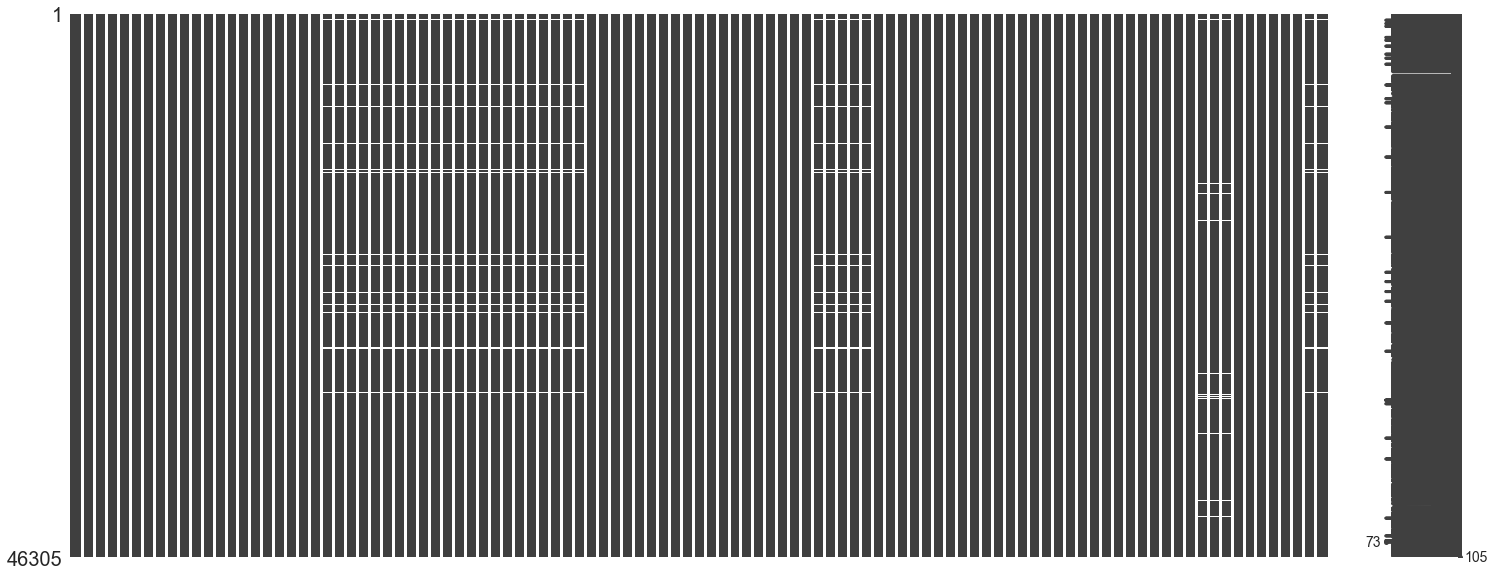

In [9]:
# Visualize no missing values
msno.matrix(peru)

In [10]:
# Visualize the distribution of each feature to get an overview of the dataset.
peru.describe(include='all')

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,refrigerator,washer,training,percapitaconsumption,poor,h_hhsize,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS
count,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,...,45306.000000,45306.000000,46305.000000,46305.000000,46305.000000,46305.000000,46305.000000,4.630500e+04,45378.000000,45378.000000
mean,5.856564,0.104244,0.307202,0.025656,0.004557,0.518734,0.007796,0.031811,0.041421,0.207947,...,0.360504,0.132565,0.500011,461.243627,0.280207,4.012094,23153.000000,1.869936e+08,5.850041,459.121087
std,0.744232,0.305580,0.461339,0.158108,0.067350,0.499654,0.087952,0.175498,0.199264,0.405843,...,0.480152,0.339108,0.500005,411.392663,0.449105,2.093215,13367.246444,1.111905e+08,0.605646,293.660060
min,2.110213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.250000,0.000000,1.000000,1.000000,1.010110e+05,4.434425,-57.498259
25%,5.344724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,209.500000,0.000000,2.000000,11577.000000,9.080021e+07,5.332906,235.941390
50%,5.876649,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,356.612100,0.000000,4.000000,23153.000000,1.828055e+08,5.871003,404.708715
75%,6.360625,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,578.607700,1.000000,5.000000,34729.000000,2.814050e+08,6.306364,611.242935
max,9.663810,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,15737.630000,1.000000,20.000000,46305.000000,4.035098e+08,7.738163,2132.653600


## 2.3 Split Train-test dataset

In [11]:
trainNaN = peru[peru['training']==1]
# train = trainNaN.dropna()
train=trainNaN.dropna(axis=0, how='any', inplace=False)
# train.isnull().sum().sum()

# train.to_csv(r'Path where you want to store the exported CSV file\File Name.csv', index = False)

#train.to_csv(r'E:\ML for EconAna\Peru\train_py.csv',index=True ,header=True)


In [12]:
test = peru[peru['training']==0]
test.head()

,lnpercapitaconsumption,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,...,refrigerator,washer,training,percapitaconsumption,poor,h_hhsize,id_for_matlab,hhid,lncaphat_OLS,percapitahat_OLS
0,5.351858,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0,211.0000,0,1,1,233710511,5.246471,284.42427
1,5.768755,0,0,0,0,1,0,0,0,0,...,1.0,0.0,0,320.1389,0,3,2,295508011,6.129468,522.88406
2,5.968277,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0,390.8318,0,4,3,257600211,6.665577,878.49612
3,5.654599,0,0,0,0,1,0,0,0,0,...,NaN,NaN,0,285.6018,1,9,4,198104311,6.088294,567.47054
4,4.771289,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0,118.0713,1,8,5,24805311,5.008170,115.49293


In [13]:
x_train = train.iloc[:,1: 97]
x_train1 = train.iloc[:,1: 97]
x_test = test.iloc[:,1: 97]
x_train.head()

,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,d_water_well,...,d_dominio_3,d_dominio_4,d_dominio_5,d_dominio_6,d_dominio_7,internet,cable,computer,refrigerator,washer
23152,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
23153,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1.0,1.0,1.0
23154,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.0,0.0,0.0
23155,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
23156,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.0,0.0,0.0


In [14]:
y_train = train.loc[:,'percapitaconsumption']
lny_train = train.loc[:,'lnpercapitaconsumption']
y_test = test.loc[:,'percapitaconsumption']
lny_test = test.loc[:,'lnpercapitaconsumption']

##impute the missing values and export it to the current directory
imr = SimpleImputer(missing_values=np.nan, strategy='median')
imr = imr.fit(x_test)
x_test = pd.DataFrame(imr.transform(x_test))
x_test.to_csv(r'Datasets\x_test_96.csv',index=True ,header=True)

In [15]:
# import x_test data
x_test = pd.read_csv('datasets/x_test_96.csv')
x_test1 = pd.read_csv('datasets/x_test_96.csv')
x_test.head()

,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,d_water_well,...,d_dominio_3,d_dominio_4,d_dominio_5,d_dominio_6,d_dominio_7,internet,cable,computer,refrigerator,washer
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,1,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
print(np.any(np.isnan(x_test)))
print(np.all(np.isfinite(x_test)))
print(np.any(np.isinf(x_test)))

False
True
False


In [17]:
x_test.isnull().sum()

d_fuel_other       0
d_fuel_wood        0
d_fuel_coal        0
d_fuel_kerosene    0
d_fuel_gas         0
                  ..
internet           0
cable              0
computer           0
refrigerator       0
washer             0
Length: 96, dtype: int64

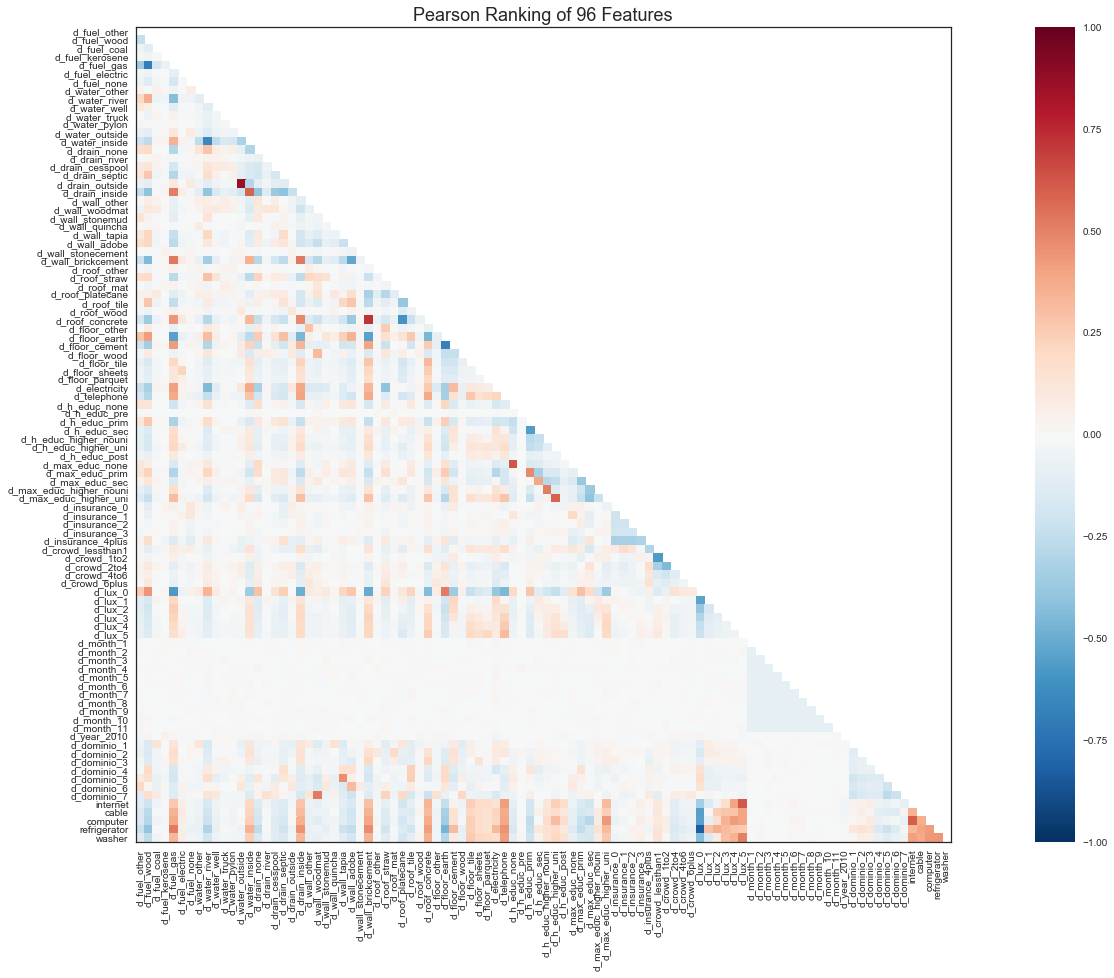

In [18]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')
fig=plt.gcf()
fig.set_size_inches(30,15)
visualizer.fit(x_train, y_train)           # Fit the data to the visualizer
visualizer.transform(x_train)        # Transform the data
visualizer.show()

In [19]:
x_test.shape

(23152, 96)

In [20]:
x_train.shape

(22191, 96)

# 3 Model implementation
## 3.1.1 Replicate the original paper(Peru): OLS

In [21]:
# add constant for train_x
x_train_72 = train.iloc[:,1: 73]
x_test_72 = x_test.iloc[:,0: 72]
one = np.ones(np.shape(x_train_72))
x_train_withcons = np.concatenate([one,x_train_72],axis=1)
# add constant for test_x
one = np.ones(np.shape(x_test_72))
x_test_withcons = np.concatenate([one,x_test_72],axis=1)

In [22]:
x_train_72.head()

,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,d_water_well,...,d_crowd_1to2,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_0,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5
23152,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
23153,0,0,0,0,1,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0,0,0,0,1,0
23154,0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,1,0,0,0,0,0
23155,0,1,0,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,1,0,0,0,0,0
23156,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1,0,0,0,0,0


In [23]:
x_test_72.head()

,d_fuel_other,d_fuel_wood,d_fuel_coal,d_fuel_kerosene,d_fuel_gas,d_fuel_electric,d_fuel_none,d_water_other,d_water_river,d_water_well,...,d_crowd_1to2,d_crowd_2to4,d_crowd_4to6,d_crowd_6plus,d_lux_0,d_lux_1,d_lux_2,d_lux_3,d_lux_4,d_lux_5
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


In [24]:
# linear regression with constant
linreg = LinearRegression()
ols = linreg.fit(x_train_withcons,y_train)

In [25]:
ols.coef_

array([-3.12256229e+10, -5.03391773e+15,  2.99299831e+15,  6.10481641e+15,
       -4.16245416e+15,  8.83051527e+15, -2.56013196e+15,  5.64440096e+14,
       -1.45623568e+15,  4.01206398e+14, -4.51309780e+14,  1.86113021e+15,
        1.40745341e+15, -1.67251797e+15, -1.76925109e+15,  1.60586686e+15,
       -3.00027099e+14, -4.13841222e+14,  1.46717124e+14,  2.04521644e+14,
       -5.81132430e+14,  4.22871475e+14, -2.96690516e+14, -1.19893161e+15,
        3.97251228e+14,  1.14321197e+15,  4.78978085e+13,  7.75875956e+14,
        9.10229697e+14,  7.52377309e+14,  6.25624845e+14, -2.94743112e+14,
        1.07649475e+14, -3.44936365e+14, -2.61241543e+14,  3.62813631e+14,
       -1.69939942e+14, -2.99010871e+14,  3.74617224e+14, -1.48977457e+14,
        7.59097342e+13,  2.98900125e+14,  6.18257541e+14,  7.22708745e+14,
       -3.98493008e+14,  6.18409144e+14,  4.92349361e+14,  1.06247324e+14,
        2.05091041e+14,  1.17193528e+14, -3.27338199e+13, -1.88755098e+14,
       -6.41510459e+13, -

In [26]:
ols_estimate_y = ols.predict(x_train_withcons)
ols_estimate_y

array([445., 805., 199., ..., 389., 329., 758.])

In [27]:
ols_pred_y = ols.predict(x_test_withcons)

In [28]:
# Linear regression by using Stata Model
x = sm.add_constant(x_train)
model2=sm.OLS(y_train,x)
results=model2.fit()
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,271.5376,14.141,19.203,0.000,243.821,299.254
d_fuel_other,-100.4283,8.378,-11.987,0.000,-116.851,-84.006
d_fuel_wood,-89.2030,7.219,-12.357,0.000,-103.353,-75.053
d_fuel_coal,-40.1382,11.701,-3.430,0.001,-63.073,-17.203
d_fuel_kerosene,-57.9007,25.350,-2.284,0.022,-107.588,-8.213
d_fuel_gas,-15.6770,6.562,-2.389,0.017,-28.540,-2.814
d_fuel_electric,436.4550,20.089,21.726,0.000,397.079,475.831
d_fuel_none,138.4298,11.108,12.462,0.000,116.658,160.202
d_water_other,34.2105,9.082,3.767,0.000,16.408,52.013
d_water_river,15.3014,6.012,2.545,0.011,3.518,27.085


## 3.1.2 Calculate MSE-OLS

In [29]:
#calculate MSE for the training dataset (from the estimation of original paper)
from sklearn import metrics

metrics.mean_squared_error(train.lncaphat_OLS,train.lnpercapitaconsumption)

0.1919835924821717

In [30]:
#calculate MSE for the training dataset (Original Paper)
metrics.mean_squared_error(train.percapitahat_OLS,train.percapitaconsumption)

77167.47406692483

In [31]:
#calculate MSE for y in the testing dataset (Original Paper)
original_pred_y = pd.DataFrame(test.percapitahat_OLS)
NaNy = original_pred_y.join(y_test)
NaNy=NaNy.dropna(axis=0, how='any', inplace=False)
NaNy.head()
print(NaNy.shape)
mse_ols_y = metrics.mean_squared_error(NaNy.percapitahat_OLS,NaNy.percapitaconsumption)
print(mse_ols_y)

(22704, 2)
89689.4794288619


In [32]:
#calculate MSE for lny in the testing dataset (Original Paper)
original_pred_lny = pd.DataFrame(test.lncaphat_OLS)
NaNlny = original_pred_lny.join(lny_test)
NaNlny=NaNlny.dropna(axis=0, how='any', inplace=False)
NaNlny.head()
print(NaNlny.shape)
mse_ols_lny = metrics.mean_squared_error(NaNlny.lncaphat_OLS,NaNlny.lnpercapitaconsumption)
print(mse_ols_lny)

(22704, 2)
0.1908680255424893


In [33]:
#calculate MSE for the training dataset (my calculation)
metrics.mean_squared_error(ols_estimate_y,y_train)

77192.08104485337

In [34]:
#calclulate MSE for the testing dataset (my calculation)
metrics.mean_squared_error(ols_pred_y, y_test)

6.358591436402691e+26

## 3.2 Model - Lasso

In [67]:
## Create new variables specifically for Lasso
#interact each of two variables in x_train, we get 4560 interactions with 96 old features.

for i in range(0,96):
    a=i
    for j in range(a+1,96):
            x_train1['interaction'+str(i)+str('t')+str(j)]=x_train1.iloc[:,i]* x_train1.iloc[:,j]

In [68]:
#interact each of two variables in x_train, we get 4560 interactions with 96 old features.
for i in range(0,96):
    a=i
    for j in range(a+1,96):
            x_test1['interaction'+str(i)+str('t')+str(j)]=x_test1.iloc[:,i]* x_test1.iloc[:,j]

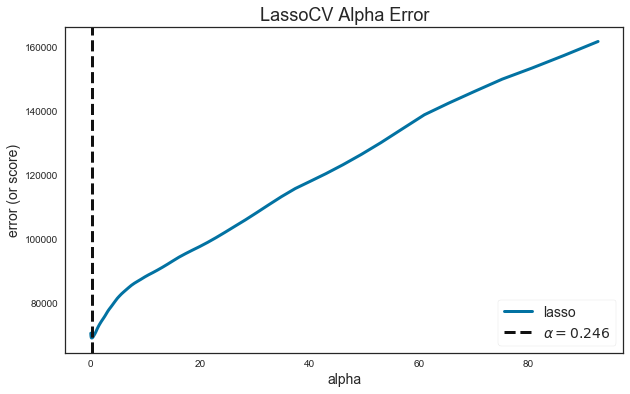

AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001E88CBA2588>,
               is_fitted='auto', model=None)

In [69]:
alphas(LassoCV(random_state=0), x_train1, y_train)

In [70]:
lassocv = LassoCV(alphas = [0.185,0.19,0.193,0.2,0.21,0.24],cv=10)
lassocv.fit(x_train1, y_train)

LassoCV(alphas=[0.185, 0.19, 0.193, 0.2, 0.21, 0.24], copy_X=True, cv=10,
        eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [71]:
lassocv.alpha_

0.21

In [72]:
lasso_estimate_y = lassocv.predict(x_train1)
metrics.mean_squared_error(lasso_estimate_y,y_train)

61528.5635551761

In [73]:
lasso_pred_y = lassocv.predict(x_test1)
mse_lasso_y = metrics.mean_squared_error(lasso_pred_y,y_test)
print(mse_lasso_y)

80288.03171922367


In [74]:
# lny
ln_lassocv = LassoCV(alphas = [0.0001,0.001,0.1,0.2,0.5],cv=10)
ln_lassocv.fit(x_train1, lny_train)

LassoCV(alphas=[0.0001, 0.001, 0.1, 0.2, 0.5], copy_X=True, cv=10, eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [75]:
ln_lassocv.alpha_

0.001

In [76]:
lasso_pred_lny = ln_lassocv.predict(x_test1)

In [77]:
# mse_lasso_lny
mse_lasso_lny = metrics.mean_squared_error(lasso_pred_lny,lny_test)
print(mse_lasso_lny)  ## alpha 0.001 mse: 0.18047432116868548

0.18047432116868548


## 3.3 Model-KNN Regression

In [60]:
random.seed(30)
sfs = SFS(KNeighborsRegressor(), 
         k_features= (30, 96),
         forward=True,
         floating=False,
         scoring='neg_mean_squared_error',
         cv=5)
sfs.fit(x_train, y_train)
sfs.k_feature_names_

('d_fuel_other',
 'd_fuel_wood',
 'd_fuel_coal',
 'd_fuel_gas',
 'd_fuel_electric',
 'd_fuel_none',
 'd_water_river',
 'd_water_truck',
 'd_water_pylon',
 'd_water_outside',
 'd_water_inside',
 'd_drain_river',
 'd_drain_septic',
 'd_drain_inside',
 'd_wall_other',
 'd_wall_stonemud',
 'd_wall_tapia',
 'd_wall_adobe',
 'd_roof_straw',
 'd_roof_mat',
 'd_roof_tile',
 'd_roof_wood',
 'd_floor_earth',
 'd_floor_tile',
 'd_floor_sheets',
 'd_floor_parquet',
 'd_telephone',
 'd_h_educ_pre',
 'd_h_educ_prim',
 'd_h_educ_sec',
 'd_h_educ_higher_nouni',
 'd_h_educ_higher_uni',
 'd_h_educ_post',
 'd_max_educ_none',
 'd_max_educ_prim',
 'd_max_educ_higher_nouni',
 'd_insurance_0',
 'd_insurance_1',
 'd_insurance_3',
 'd_insurance_4plus',
 'd_crowd_lessthan1',
 'd_crowd_1to2',
 'd_crowd_2to4',
 'd_lux_0',
 'd_lux_1',
 'd_lux_2',
 'd_lux_3',
 'd_lux_4',
 'd_lux_5',
 'd_month_3',
 'd_month_6',
 'd_month_8',
 'd_month_9',
 'd_year_2010',
 'd_dominio_1',
 'd_dominio_2',
 'd_dominio_3',
 'd_dominio_4'

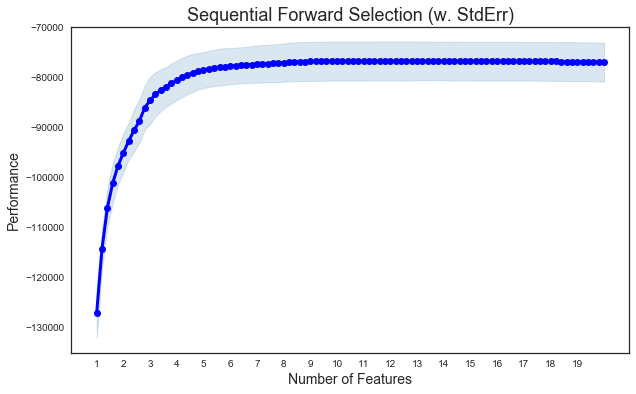

In [61]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
ticks = np.arange(1, 96, 5)
plt.xticks(ticks)
plt.show()

In [62]:
x_train_sfs = sfs.transform(x_train)
x_test_sfs = sfs.transform(x_test)

In [63]:
x_train_knn = pd.DataFrame(x_train_sfs)
x_test_knn = pd.DataFrame(x_test_sfs)

In [64]:
# create a knn regression model (best-fitted parameter is k=37)
param_dict = {'n_neighbors':[37], 'weights': ['distance'], 'metric':['hamming']}
knn_gscv = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_dict,scoring='neg_mean_squared_error', cv=5)
knn_gscv.fit(x_train_knn, y_train)
knn_gscv.best_params_

{'metric': 'hamming', 'n_neighbors': 37, 'weights': 'distance'}

In [65]:
train_knn_pred = knn_gscv.predict(x_train_knn)
print(metrics.mean_squared_error(train_knn_pred, y_train))

3057.958463518474


In [66]:
# mse for y
knn_pred_y = knn_gscv.predict(x_test_knn)
mse_knn_y = metrics.mean_squared_error(knn_pred_y, y_test)
print(mse_knn_y)

90780.47927757952


In [88]:
# create a knn regression model
param_dict = {'n_neighbors':[17, 37, 57], 'weights': ['distance'], 'metric':['hamming']}
ln_knn_gscv = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_dict,scoring='neg_mean_squared_error', cv=5)
ln_knn_gscv.fit(x_train_knn, lny_train)
ln_knn_gscv.best_params_

{'metric': 'hamming', 'n_neighbors': 37, 'weights': 'distance'}

In [89]:
# mse for lny
knn_pred_lny = ln_knn_gscv.predict(x_test_knn)
mse_knn_lny = metrics.mean_squared_error(knn_pred_lny, lny_test)
print(mse_knn_lny)

0.20991093774748923


## 3.4 SVM Regression (SVR)

#Code for CV: 
params_dict={'C':[10,100,300],'gamma':[0.01,0.1,1],'kernel':['rbf']}
params_dict={'C':[300],'gamma':[0.1],'kernel':['rbf']}
svr_gscv=GridSearchCV(estimator=SVR(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=5)


In [37]:
# After using CV, we have found the best-fitted parameter, 
# so we directly use the selected parameter in the later programing for saving time

svr_gscv=SVR(C = 300, gamma = 0.1, kernel = 'rbf')
svr_gscv.fit(x_train,y_train)

SVR(C=300, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [38]:
# MSE for the training set
svr_estimate_y = svr_gscv.predict(x_train)
metrics.mean_squared_error(svr_estimate_y,y_train)

56010.9428618192

In [39]:
# predict for x_test
svr_pred_y = svr_gscv.predict(x_test)
# calculate MSE from the prediction for x_test and y_test
mse_svr_y = metrics.mean_squared_error(svr_pred_y, y_test)  ##300 and 0.1 mse:  ## 84657.0160
print(mse_svr_y)

84657.01604518267


#lny; Code for CV: 
params_dict={'C':[1,10,300],'gamma':[0.01,0.1,1,10],'kernel':['rbf']}
svr_gscv=GridSearchCV(estimator=SVR(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=5)
svr_gscv.fit(x_train,lny_train)
print(svr_gscv.best_params_)

In [102]:
#lny; 

# After using CV, we have found the best-fitted parameter, 
# so we directly use the selected parameter in the later programing for saving time
lny_svr_gscv=SVR(C = 100 , gamma = 0.001, kernel = 'rbf')
lny_svr_gscv.fit(x_train,lny_train)

# predict for x_test
svr_pred_lny = lny_svr_gscv.predict(x_test)

# calculate MSE from the prediction for x_test and lny_test
mse_svr_lny = metrics.mean_squared_error(svr_pred_lny, lny_test)  ##
print(mse_svr_lny)

0.17923064710220138


## 3.5 LightGBM

In [41]:
x_try = x_train.iloc[0:22673,]
y_try = y_train.iloc[0:22673,]

#code for cv: 
params_dict={'num_leaves':[5,10,15,20,25,31],'n_estimators':[20, 40, 60, 80, 97, 100],'learning_rate':[0.01, 0.1, 0.3, 0.5, 0.7]}

In [42]:
# After using CV, we have found the best-fitted parameter, 
# so we directly use the selected parameter in the later programing for saving time
params_dict={'num_leaves':[31],'n_estimators':[97],'learning_rate':[0.01, 0.1, 0.3]}
lgbm_gscv=GridSearchCV(estimator=LGBMRegressor(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=10)
lgbm_gscv.fit(x_try, y_try)
lgbm_gscv.best_params_

{'learning_rate': 0.1, 'n_estimators': 97, 'num_leaves': 31}

In [43]:
lgbm_pred_y = lgbm_gscv.predict(x_test)

In [44]:
mse_lgbm_y = metrics.mean_squared_error(lgbm_pred_y, y_test)
print(mse_lgbm_y)

80546.35227972006


In [95]:
#prediction for lny
lny_try = lny_train.iloc[0:22673,]
params_dict={'num_leaves':[5,10,20,25],'n_estimators':[20,100,500,1000,1500],'learning_rate':[0.02,0.04,0.05,0.06,0.1]}
lgbm_gscv=GridSearchCV(estimator=LGBMRegressor(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=10)
lgbm_gscv.fit(x_try, lny_try)
print(lgbm_gscv.best_params_)
lgbm_pred_lny = lgbm_gscv.predict(x_test)

# mse for lny
mse_lgbm_lny = metrics.mean_squared_error(lgbm_pred_lny, lny_test)
print(mse_lgbm_lny)

{'learning_rate': 0.04, 'n_estimators': 1500, 'num_leaves': 10}
0.17864507664424056


## 3.6 Neural Network

#code for cv: 
params_dict={'hidden_layer_sizes':[(5),(10),(20),(10,8),(10,10),(20,10)]}
clf_nn =GridSearchCV(estimator = neural_network.MLPRegressor(activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001, power_t=0.5, max_iter=500 ,tol=1e-4),param_grid=params_dict,cv=5)

In [40]:
# After using CV, we have found the best-fitted parameter, 
# so we directly use the selected parameter in the later programing for saving time
clf_nn = MLPRegressor(random_state=1, max_iter=500).fit(x_train, y_train) 
nn_estimate_y=clf_nn.predict(x_train)
print(metrics.mean_squared_error(nn_estimate_y, y_train))

nn_pred_y=clf_nn.predict(x_test)
mse_nn_y = metrics.mean_squared_error(nn_pred_y, y_test)
print(mse_nn_y)

60146.973467169766
81377.09921569008


In [113]:
#prediction for lny 
params_dict={'hidden_layer_sizes':[(5),(10),(10,10),(20,10)]}
clf_nn =GridSearchCV(estimator = neural_network.MLPRegressor(activation="relu",
                 solver='adam', alpha=0.3,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.005, power_t=0.5, max_iter=500 ,tol=1e-4),param_grid=params_dict,cv=5)
clf_nn.fit(x_train,lny_train)
print(clf_nn.best_params_)
nn_pred_lny = clf_nn.predict(x_test)
mse_nn_lny = metrics.mean_squared_error(nn_pred_lny, lny_test)
print(mse_nn_lny)

{'hidden_layer_sizes': (10, 10)}
0.18699041083015602


# 4 Evaluation of different variables

In [114]:
model_names=['OLS','Lasso','KNN','SVR','LGBM','NN']
mse_pred_y=(mse_ols_y,mse_lasso_y,mse_knn_y,mse_svr_y,mse_lgbm_y,mse_nn_y)
d={'Modelling Algo':model_names,'MSE':mse_pred_y}
d

{'Modelling Algo': ['OLS', 'Lasso', 'KNN', 'SVR', 'LGBM', 'NN'],
 'MSE': (89689.4794288619,
  80288.03171922367,
  90780.47927757952,
  84657.01604518267,
  80546.35227972006,
  81377.09921569008)}

In [115]:
acc_frame=pd.DataFrame(d)
acc_frame

,Modelling Algo,MSE
0,OLS,89689.479429
1,Lasso,80288.031719
2,KNN,90780.479278
3,SVR,84657.016045
4,LGBM,80546.352280
5,NN,81377.099216


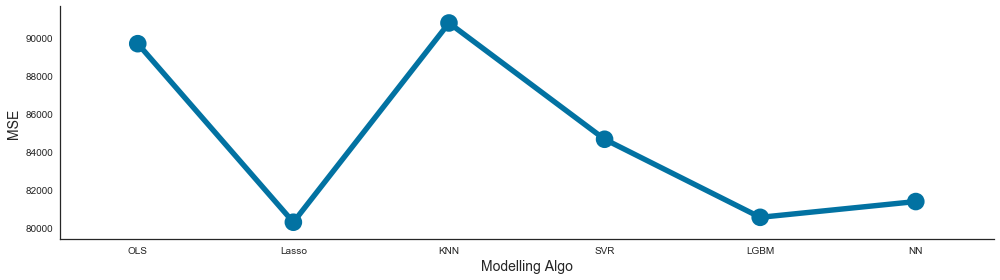

In [116]:
sns.factorplot(x='Modelling Algo',y='MSE',data=acc_frame,kind='point',size=4,aspect=3.5)

In [117]:
# for lny
model_names=['OLS','Lasso','KNN','SVR','LGBM','NN']
mse_pred_lny=(mse_ols_lny,mse_lasso_lny,mse_knn_lny,mse_svr_lny,mse_lgbm_lny,mse_nn_lny)
d2={'Modelling Algo':model_names,'MSE_lny':mse_pred_lny}
d2

{'Modelling Algo': ['OLS', 'Lasso', 'KNN', 'SVR', 'LGBM', 'NN'],
 'MSE_lny': (0.1908680255424893,
  0.18047432116868548,
  0.20991093774748923,
  0.17923064710220138,
  0.17864507664424056,
  0.18699041083015602)}

In [118]:
acc_frame2=pd.DataFrame(d2)
acc_frame2

,Modelling Algo,MSE_lny
0,OLS,0.190868
1,Lasso,0.180474
2,KNN,0.209911
3,SVR,0.179231
4,LGBM,0.178645
5,NN,0.186990


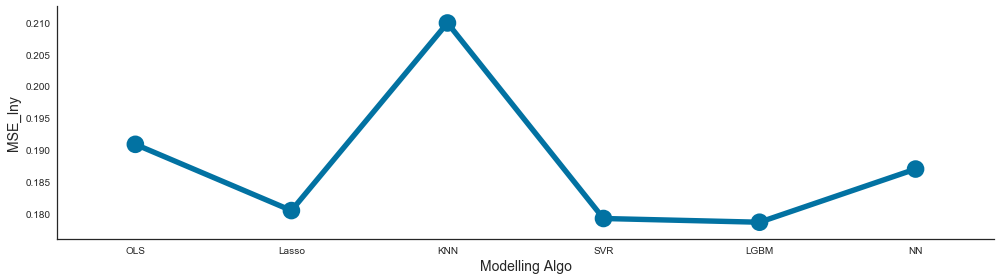

In [143]:
sns.factorplot(x='Modelling Algo',y='MSE_lny',data=acc_frame2, kind='point',style="whitegrid", color_codes=True,size=4,aspect=3.5)

# 5 Export Prediction

In [147]:
#combine the original test dataset and the precise predicted y
lasso_pred_y = pd.DataFrame(lasso_pred_y)
lasso_out = lasso_pred_y.join(test)
lasso_out.to_csv(r'Datasets\lasso_out.csv',index=True ,header=True)

knn_pred_y = pd.DataFrame(knn_pred_y)
knn_out = knn_pred_y.join(test)
knn_out.to_csv(r'Datasets\knn_out.csv',index=True ,header=True)

svr_pred_y = pd.DataFrame(svr_pred_y)
svr_out = svr_pred_y.join(test)
svr_out.to_csv(r'Datasets\svr_out.csv',index=True ,header=True)

lgbm_pred_y = pd.DataFrame(lgbm_pred_y)
lgbm_out = lgbm_pred_y.join(test)
lgbm_out.to_csv(r'Datasets\lgbm_out.csv',index=True ,header=True)

nn_pred_y = pd.DataFrame(nn_pred_y)
nn_out = nn_pred_y.join(test)
nn_out.to_csv(r'Datasets\nn_out.csv',index=True ,header=True)

In [148]:
lasso_pred_lny = pd.DataFrame(lasso_pred_lny)
lasso_out_lny = lasso_pred_lny.join(test)
lasso_out_lny.to_csv(r'Datasets\lasso_out_lny.csv',index=True ,header=True)

knn_pred_lny = pd.DataFrame(knn_pred_lny)
knn_out_lny = knn_pred_lny.join(test)
knn_out_lny.to_csv(r'Datasets\knn_out_lny.csv',index=True ,header=True)

svr_pred_lny = pd.DataFrame(svr_pred_lny)
svr_out_lny = svr_pred_lny.join(test)
svr_out_lny.to_csv(r'Datasets\svr_out_lny.csv',index=True ,header=True)

lgbm_pred_lny = pd.DataFrame(lgbm_pred_lny)
lgbm_out_lny = lgbm_pred_lny.join(test)
lgbm_out_lny.to_csv(r'Datasets\lgbm_out_lny.csv',index=True ,header=True)

nn_pred_lny = pd.DataFrame(nn_pred_lny)
nn_out_lny = nn_pred_lny.join(test)P
nn_out_lny.to_csv(r'Datasets\nn_out_lny.csv',index=True ,header=True)